In [1]:
! pip install awswrangler

     |████████████████████████████████| 174 kB 8.6 MB/s eta 0:00:01
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached redshift_connector-2.0.876-py3-none-any.whl (81 kB)
  Using cached pandas-1.2.3-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Using cached requests-2.23.0-py2.py3-none-any.whl (58 kB)
  Using cached beautifulsoup4-4.7.1-py3-none-any.whl (94 kB)
  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
  Using cached scramp-1.2.2-py3-none-any.whl (7.8 kB)
  Using cached lxml-4.6.2-cp37-cp37m-manylinux1_x86_64.whl (5.5 MB)
  Using cached asn1crypto-1.4.0-py2.py3-none-any.whl (104 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.22.0
    Uninstalling requests-2.22.0:
      Successfully uninstalled requests-2.22.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.8.2
    Uninstalling beautifulsoup4-4.8.2:
      Successfully uninstalled beautifulsoup4-4.8.2
  Attempting uninstall: pytz
   

In [2]:
import awswrangler as wr
import pandas as pd
from datetime import date

In [3]:

folder_dict={'2018':['04','05','06','07','08','09','10','11','12'],'2019':['01','02','03']}

month_map={'01':'January','02':'February','03':'March','04':"April",'05':'May','06':'June','07':'July',
           '08':'August','09':'September','10':'October','11':'November','12':'December'}

col_names = ["tagname",'timestamp','value']



In [4]:
# index = pd.date_range(start='2018-01-01', end='2020-04-27', periods=10, freq='D')
def fetch_data(variable):
    
    df_var = pd.DataFrame(columns=col_names[2:])
    
   
    
    for key,value in folder_dict.items():
         
        for month in value:
            print(variable,month)
            try:
                p = f's3://stmvpdata001/connacher-extract/Algar/{key}/{month}/{variable}_{month_map[month]}{key}.csv'
            
                df = wr.s3.read_csv(path=p,
                                    names=col_names,
                                    parse_dates=["timestamp"],
                                    low_memory = False # Hint to parse these columns as date instead of strings
                                    ).filter(['timestamp','value'])
            except:
                continue
            df['timestamp'] = pd.to_datetime(df['timestamp']) 
            df = df.set_index('timestamp')
            
            df['value'] = pd.to_numeric(df['value'], errors='coerce') 
            print(df.dtypes)
            df = df.resample('60Min').agg('mean')
            df_var = pd.concat([df_var, df]) 


    return {variable: df_var}

In [5]:
df_dict = {}
variables = ['ALGARW.VT54140.SCALED', 'ALGARW.PT54101.SCALED','ALGARW.TT54160.SCALED']
from multiprocessing.pool import ThreadPool
pool=ThreadPool(2)
result = pool.map(fetch_data, (variable for variable in variables), 4)

ALGARW.VT54140.SCALED 04
value    float64
dtype: object
ALGARW.VT54140.SCALED 05
value    float64
dtype: object
ALGARW.VT54140.SCALED 06
value    float64
dtype: object
ALGARW.VT54140.SCALED 07
value    float64
dtype: object
ALGARW.VT54140.SCALED 08
value    float64
dtype: object
ALGARW.VT54140.SCALED 09
value    float64
dtype: object
ALGARW.VT54140.SCALED 10
value    float64
dtype: object
ALGARW.VT54140.SCALED 11
value    float64
dtype: object
ALGARW.VT54140.SCALED 12
value    float64
dtype: object
ALGARW.VT54140.SCALED 01
value    float64
dtype: object
ALGARW.VT54140.SCALED 02
value    float64
dtype: object
ALGARW.VT54140.SCALED 03
value    float64
dtype: object
ALGARW.PT54101.SCALED 04
value    float64
dtype: object
ALGARW.PT54101.SCALED 05
value    float64
dtype: object
ALGARW.PT54101.SCALED 06
value    float64
dtype: object
ALGARW.PT54101.SCALED 07
value    float64
dtype: object
ALGARW.PT54101.SCALED 08
value    float64
dtype: object
ALGARW.PT54101.SCALED 09
value    float64
dtype:

In [6]:
for item in result:
    df_dict.update(item)

In [9]:
def line_plot(dataframe, span, title, time_column_name,interval, x_axis_name, y_axis_name):
  
    from matplotlib import style
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.dates import DateFormatter
    

    style.use('classic')
    fig,ax = plt.subplots(figsize=(20,5))
    dataframe = dataframe.loc[span[0]:span[1]]
    plt.plot(dataframe['value'])  
    fig.patch.set_facecolor('xkcd:white')
    ax.set_facecolor('xkcd:white')
    date_form = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)
    
    #   plt.plot(dataframe[tag_name])
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(x_axis_name, fontsize=20, fontweight='bold')
    plt.ylabel(y_axis_name, fontsize=20, fontweight='bold')
    plt.show()

In [11]:
span = ['2018-06-1','2019-03-30']

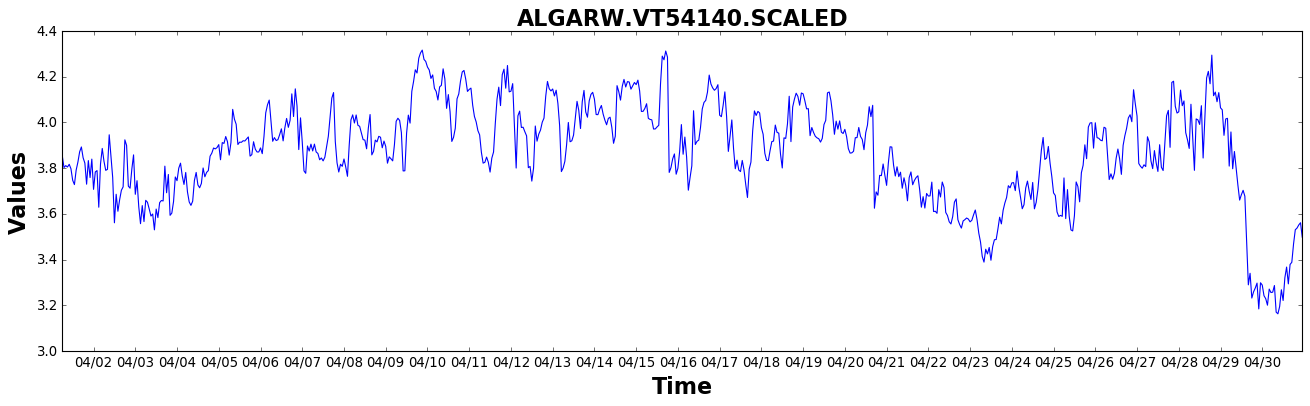

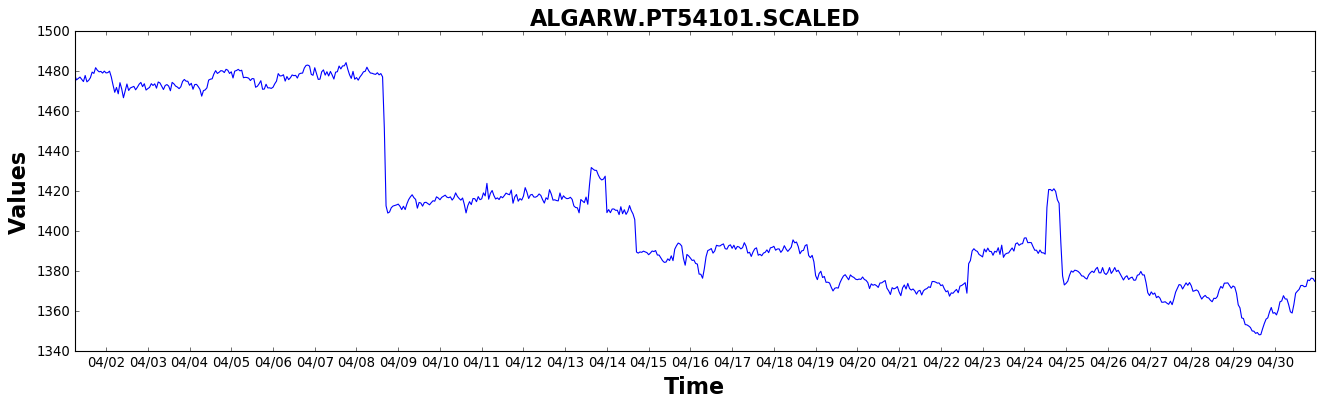

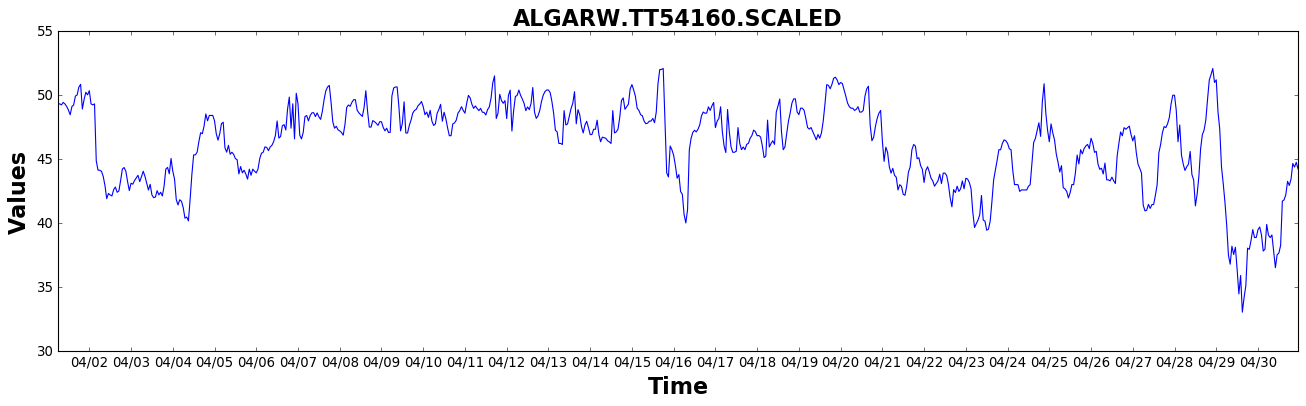

In [10]:
#18-04-2018 08:18	19-04-2018 17:24	NULL	NULL	19-04-2018 13:14	BFW Pump A
#Vibration increase Pressure decrease Temp increase

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2018-04-1','2018-04-30'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2018-04-1','2018-04-30'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2018-04-1','2018-04-30'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')



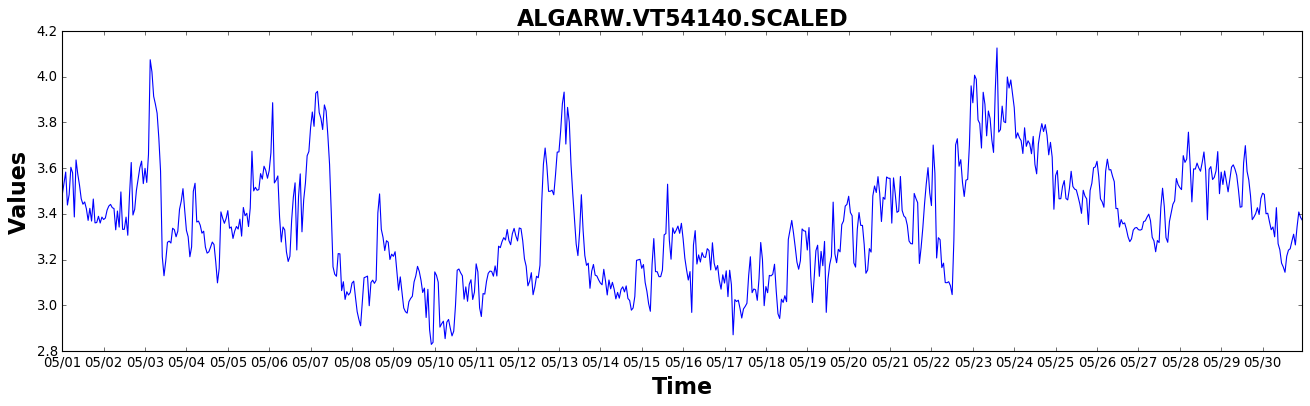

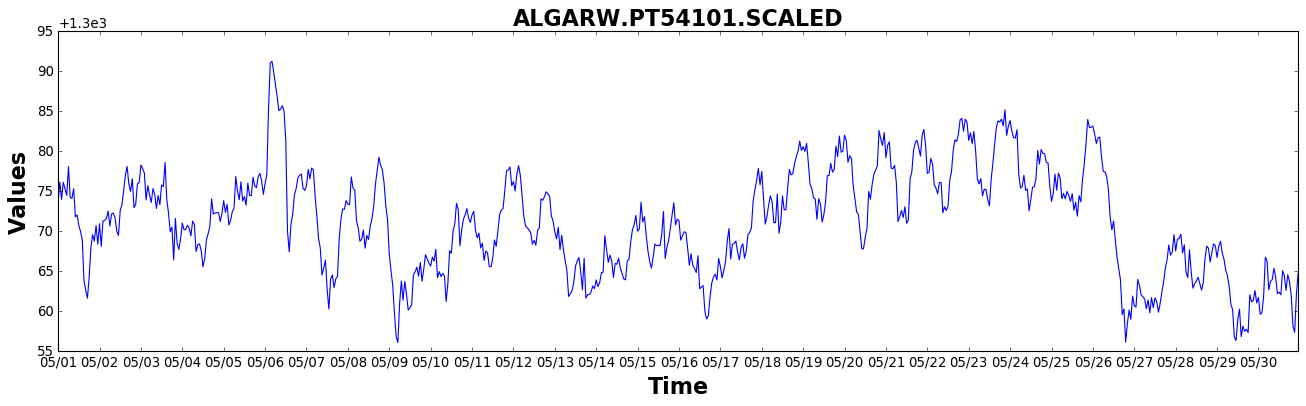

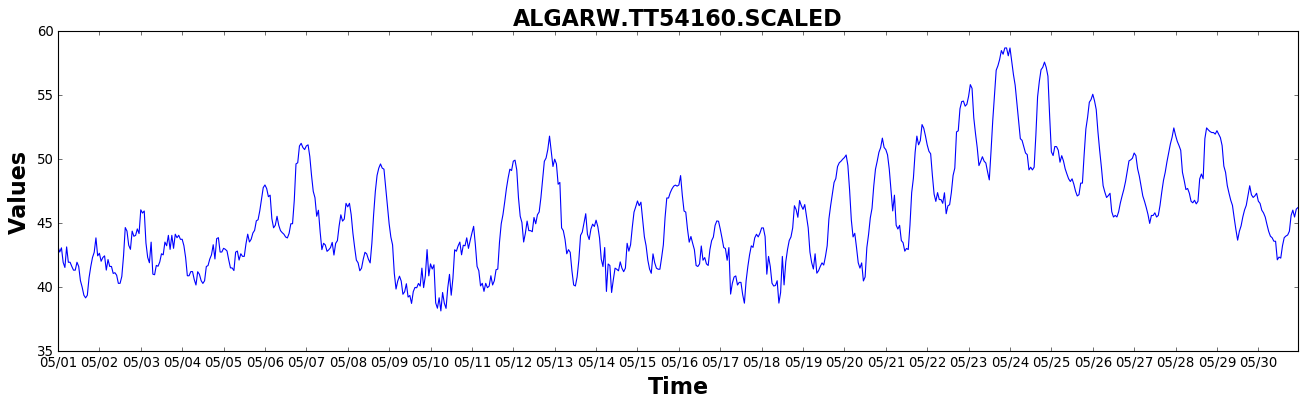

In [11]:
#Leaking consisent with vibration, pressure, temperature decrease
#13-05-2018 07:10	30-12-2018 23:15	03-07-2018 06:55	03-07-2018 16:21	P-541A mechanical seal is leaking on the non drive end

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2018-05-1','2018-05-30'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2018-05-1','2018-05-30'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2018-05-1','2018-05-30'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')


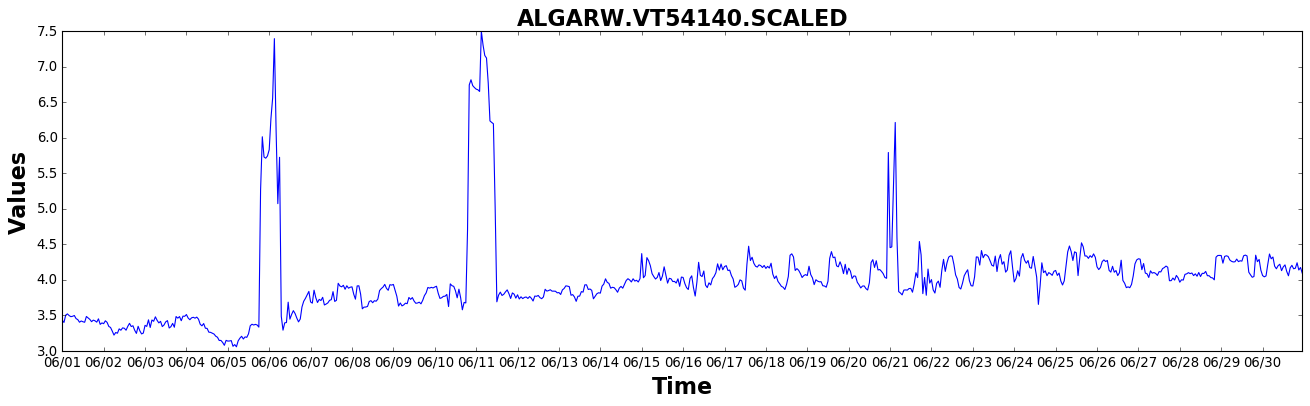

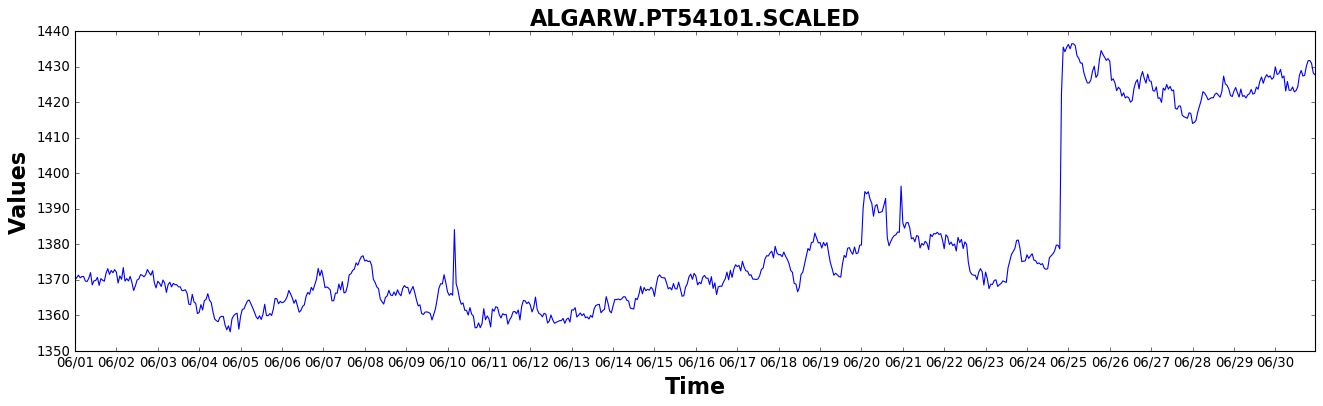

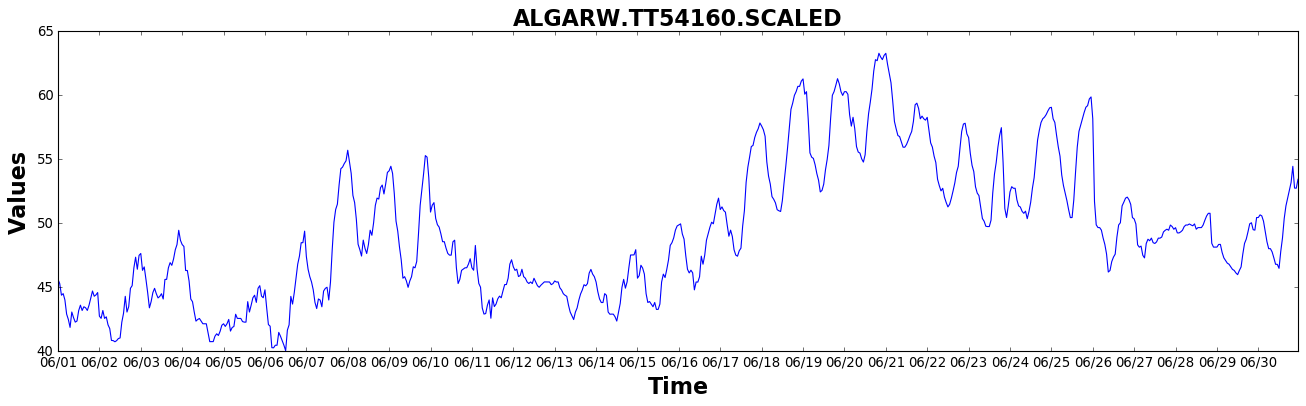

In [12]:
#Discuss temp constantly raising before trip
#21-06-2018 07:26	23-12-2018 23:15	26-06-2018 06:55	26-06-2018 08:28	P-541A vibration trip

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2018-06-1','2018-06-30'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2018-06-1','2018-06-30'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2018-06-1','2018-06-30'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')

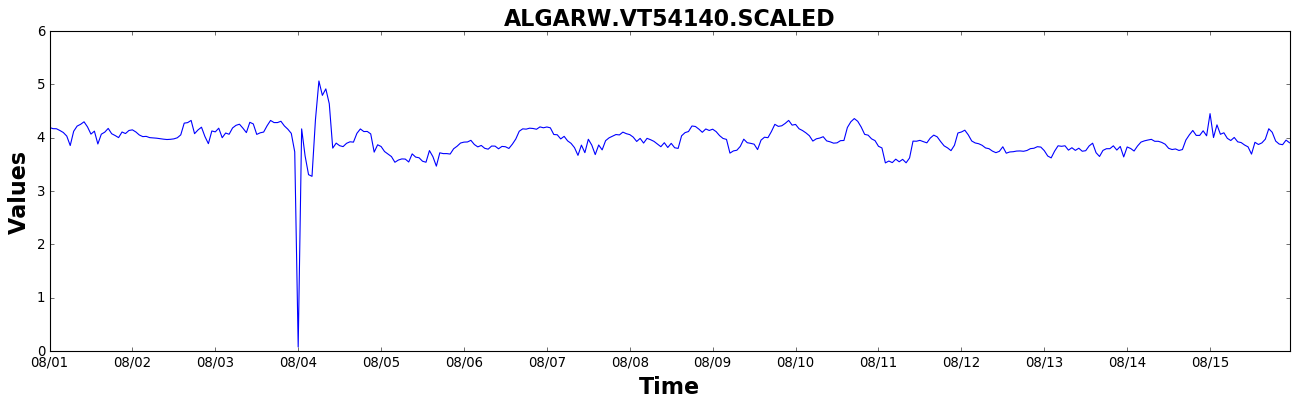

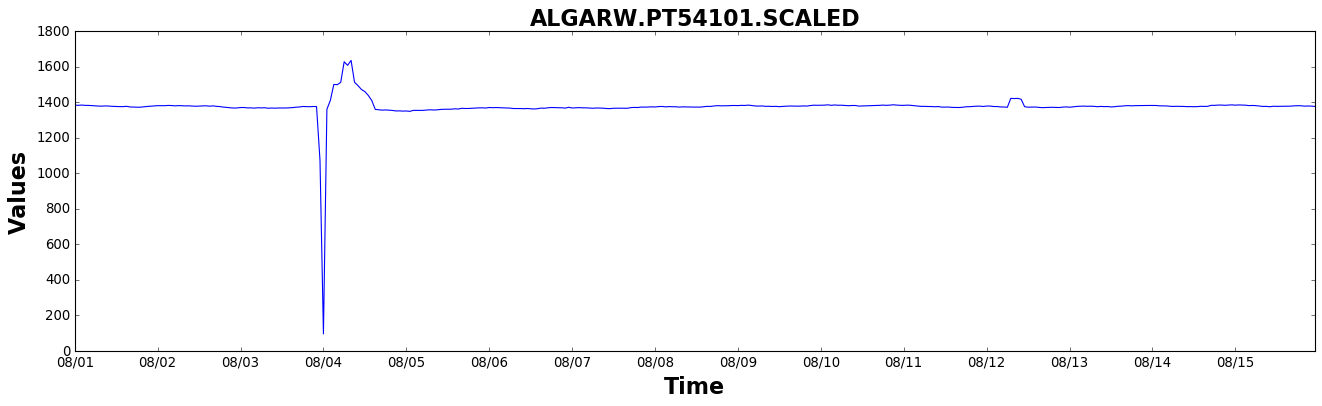

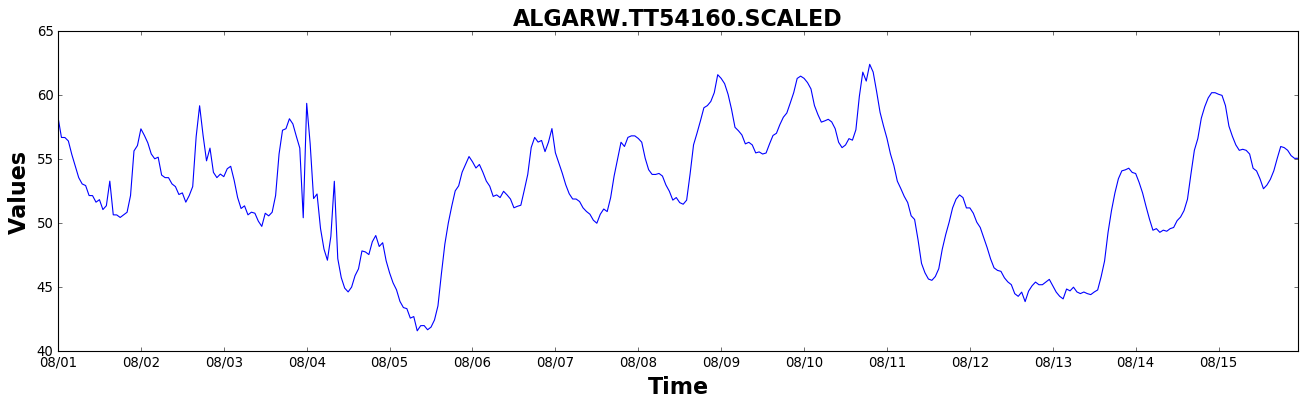

In [13]:
#09-08-2018 07:00	11-04-2019 23:15	12-10-2018 08:48	13-10-2018 10:44	D.E. Mechanical seal small drip started on pump

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2018-08-1','2018-08-15'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2018-08-1','2018-08-15'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2018-08-1','2018-08-15'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')

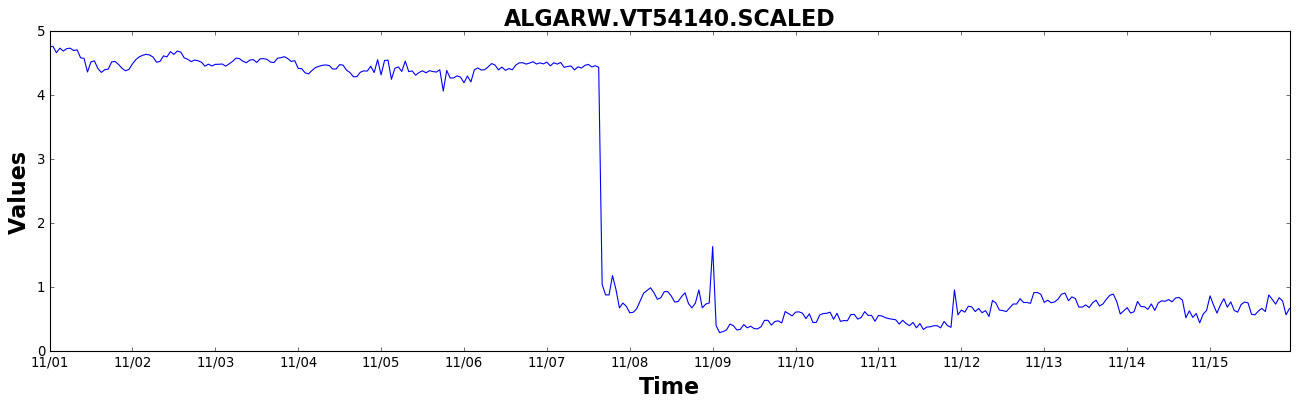

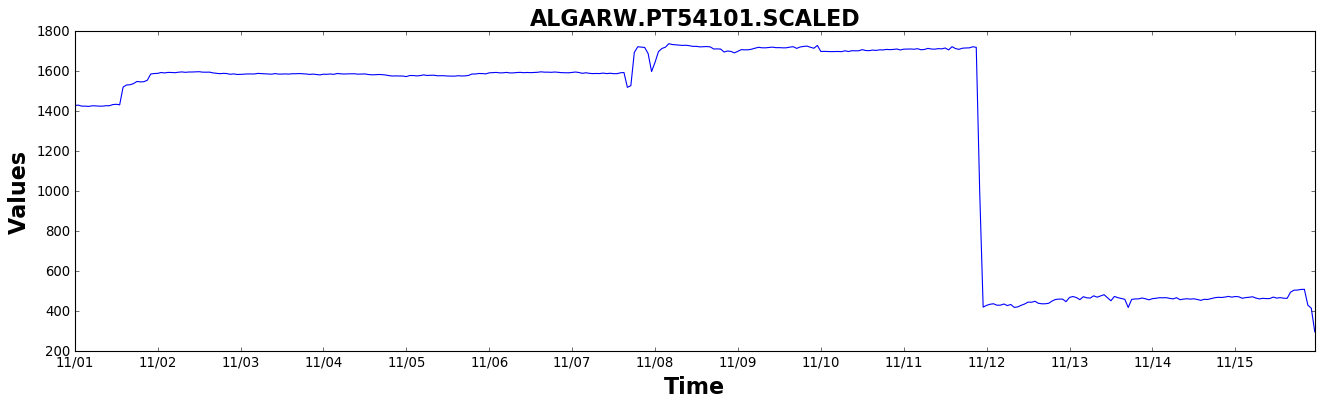

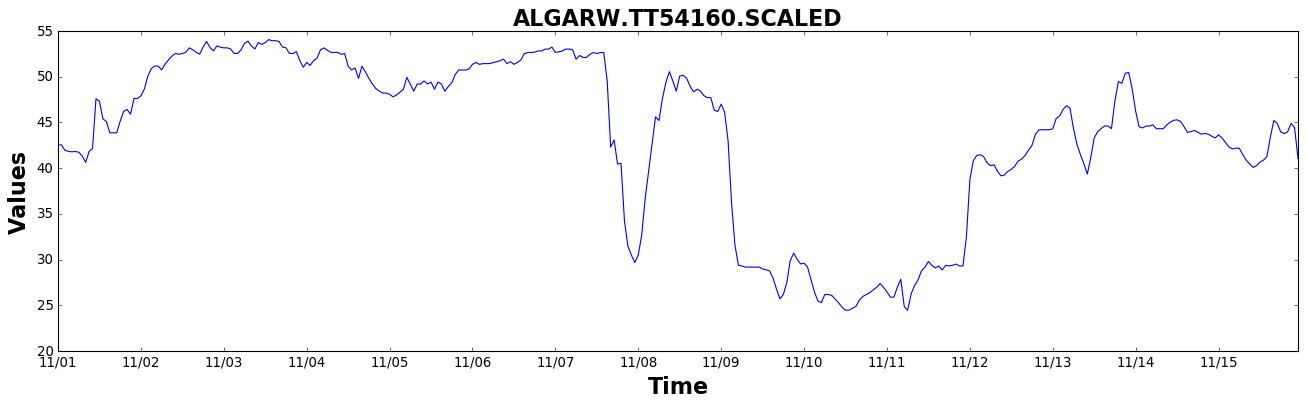

In [14]:
#Vibration showed before seize once seized pressure temperature increased
#08-11-2018 18:05	11-11-2018 15:49	NULL	NULL	09-11-2018 07:25	P-541A HPBFWP suction valve seized

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2018-11-1','2018-11-15'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2018-11-1','2018-11-15'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2018-11-1','2018-11-15'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')

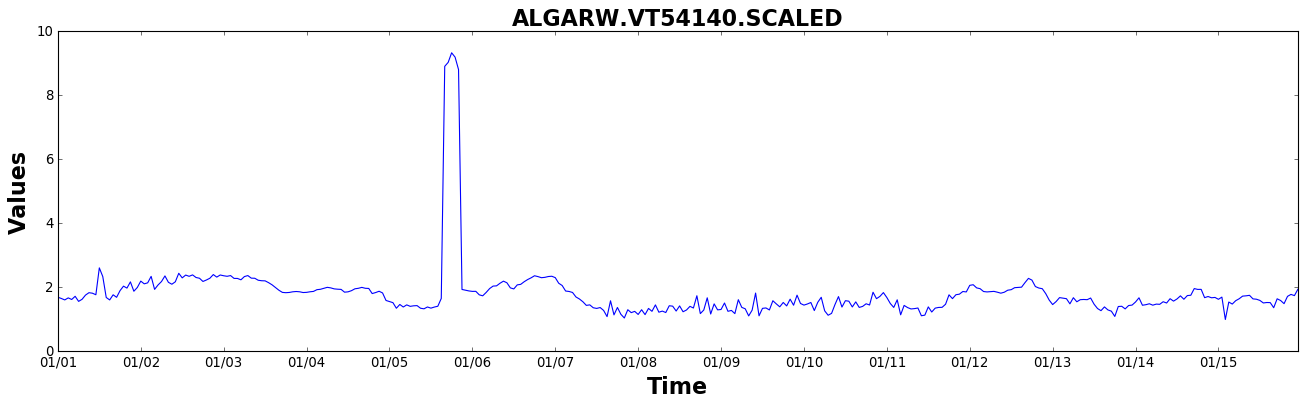

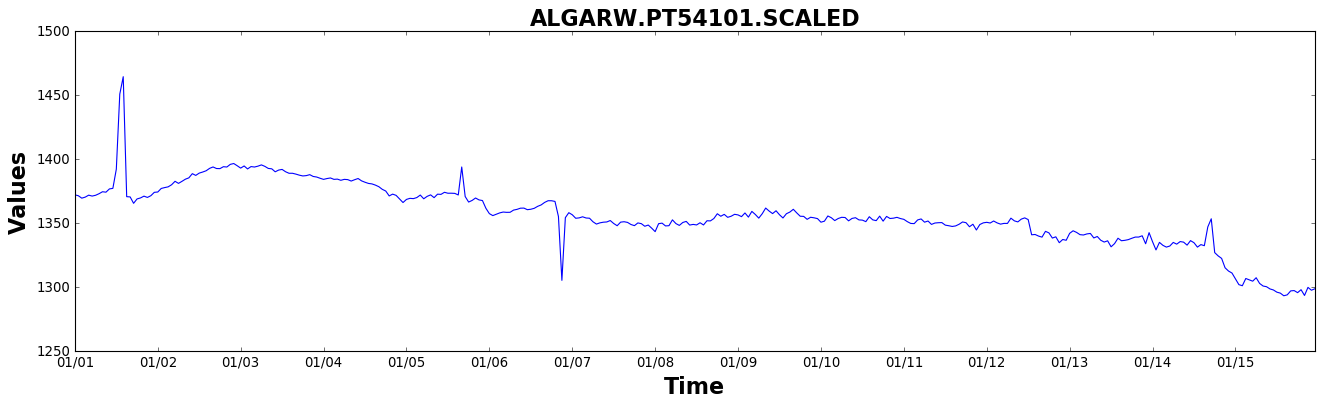

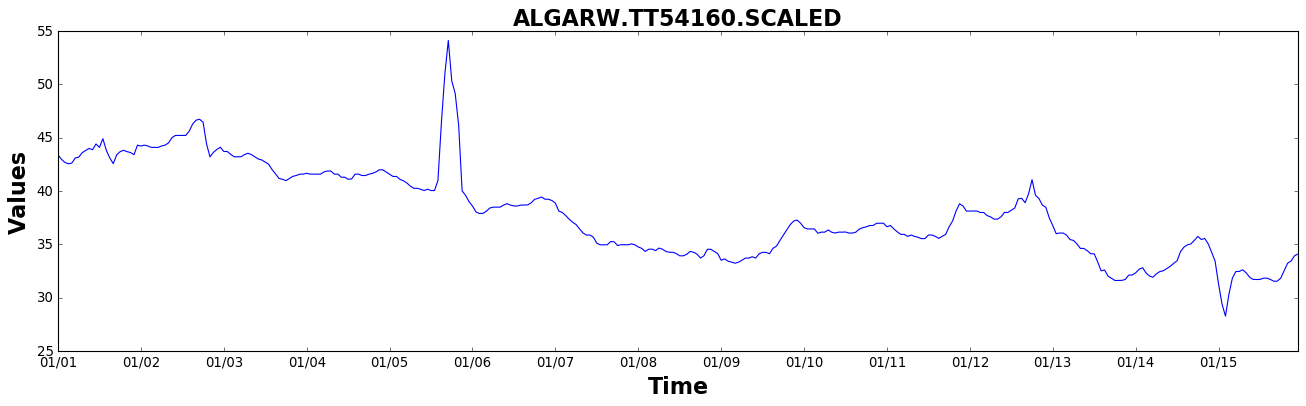

In [15]:
#03-01-2019 07:05	05-04-2020 23:15	07-10-2019 16:46	08-10-2019 09:40	Check alignment--see notes

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2019-01-1','2019-01-15'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2019-01-1','2019-01-15'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2019-01-1','2019-01-15'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')

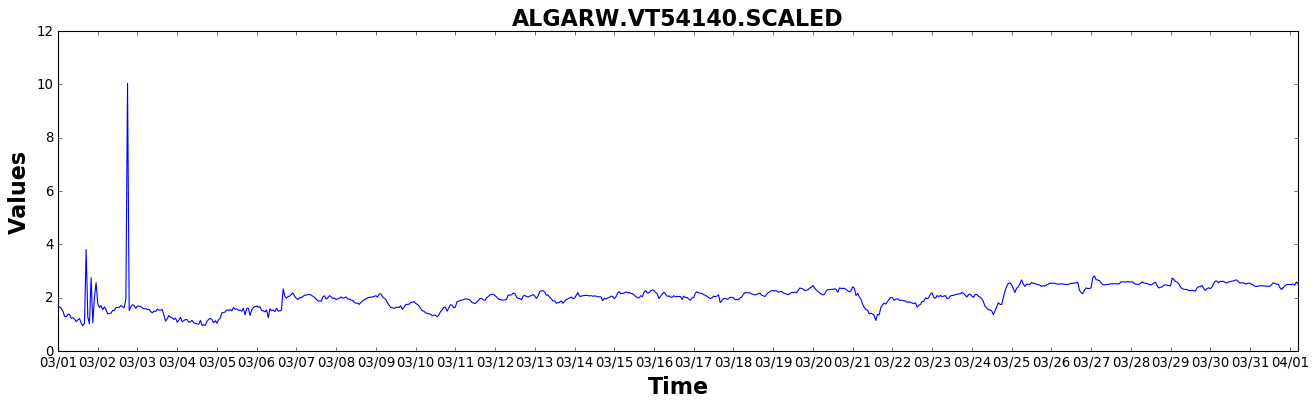

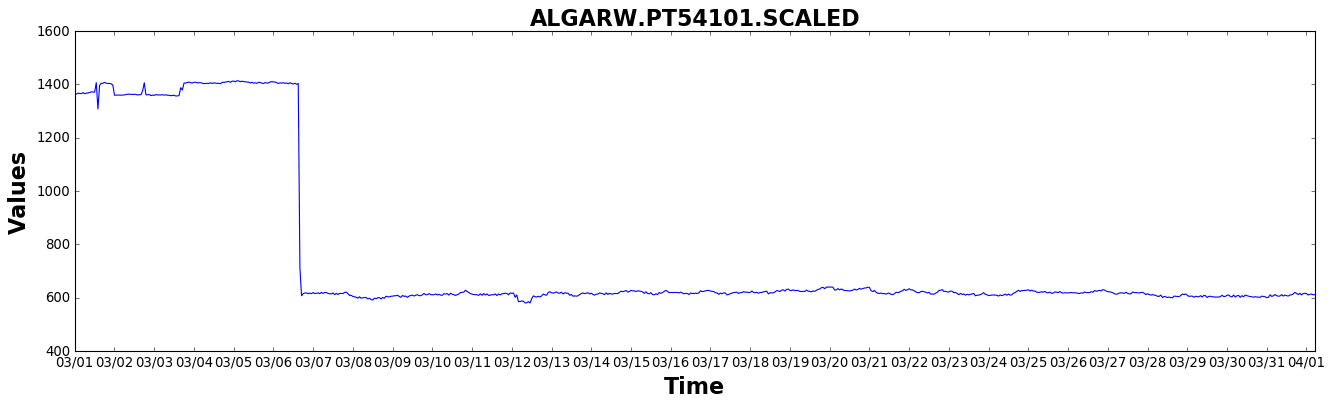

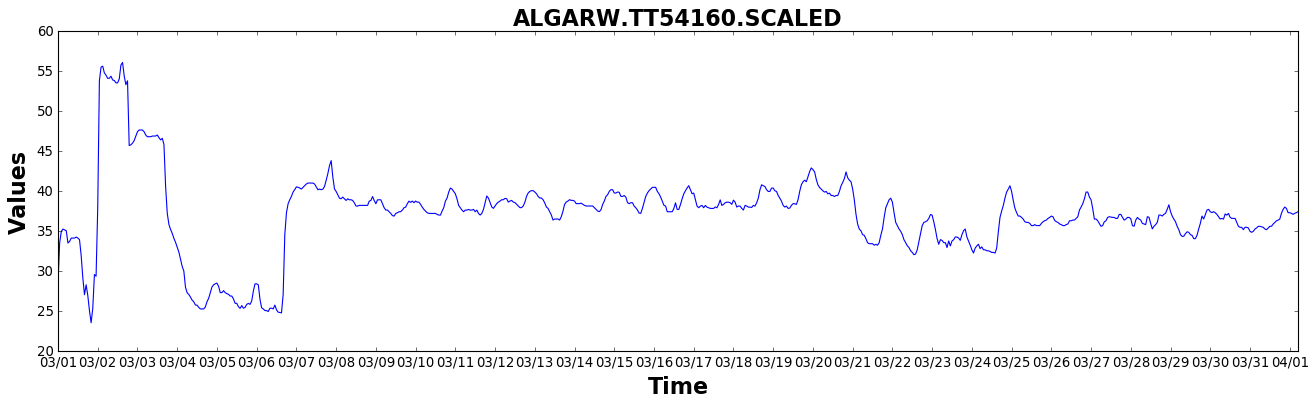

In [16]:
#02-03-2019 06:45	10-04-2020 23:15	04-03-2019 07:13	13-10-2019 17:25	P-541A HP BFW Motor - Bump test new motor for rotation and tale IR scans when running
#Alignment issues visible with increase in vibration, decrease pressure, temperature but slightly
#25-03-2020 08:42	29-03-2020 08:54	29-03-2020 08:32	29-03-2020 08:54	P-541A alignment/troubleshooting
#28-03-2020 17:24	01-04-2020 07:49	01-04-2020 06:41	01-04-2020 07:49	Request to lockout 4160v on P-541-A HP BFW Pump for alignment

line_plot(df_dict['ALGARW.VT54140.SCALED'], ['2019-03-1','2019-04-5'], 'ALGARW.VT54140.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.PT54101.SCALED'], ['2019-03-1','2019-04-5'], 'ALGARW.PT54101.SCALED', 'timestamp',1,'Time', 'Values')
line_plot(df_dict['ALGARW.TT54160.SCALED'], ['2019-03-1','2019-04-5'], 'ALGARW.TT54160.SCALED', 'timestamp',1,'Time', 'Values')